In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import requests
import json
import random
from google.colab import userdata
from google import genai

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:502: UserWarning: <built-in function any> is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(


In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.57MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 58.3kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.32MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.fc1 = nn.Linear(64 * 7 * 7, 128)
    self.fc2 = nn.Linear(128, 10)
  def forward(self, x):
    x = self.pool(torch.relu(self.conv1(x)))
    x = self.pool(torch.relu(self.conv2(x)))
    x = x.view(-1, 64 * 7 * 7)
    x = torch.relu(self.fc1(x))
    x = self.fc2(x)
    return x

model = CNN()

In [4]:
def train(epochs, trainloader, model):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in trainloader:
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")

In [5]:
train(3, trainloader, model)

Epoch 1, Loss: 0.1514292194911126
Epoch 2, Loss: 0.0441501799371165
Epoch 3, Loss: 0.030048510459116298


In [6]:
def evaluate(testloader, model):
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in testloader:
      outputs = model(images)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  print(f"Test Accuracy: {100 * correct / total:.2f}%")

In [7]:
evaluate(testloader, model)

Test Accuracy: 99.05%


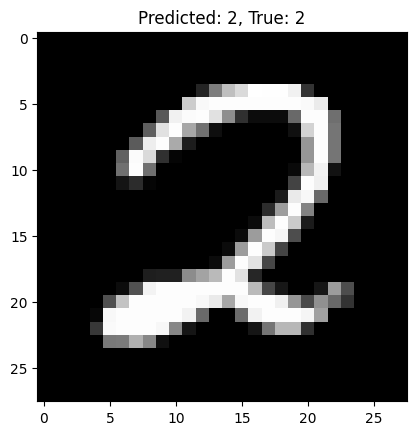

In [8]:
def show_pred(testloader, model, imtype=None):
  dataiter = iter(testloader)
  images, labels = next(dataiter)
  index = random.randint(0, len(images) - 1)
  img = images[index].squeeze()
  true_label = labels[index].item()
  output = model(images[index].unsqueeze(0))
  predicted_label = torch.argmax(output).item()
  if imtype is not None:
    plt.imshow(img.numpy(), cmap=imtype)
  else:
    img = img.permute(1, 2, 0) # imshow expects H x W x C
    plt.imshow(img.numpy())
  plt.title(f"Predicted: {predicted_label}, True: {true_label}")
  plt.show()
  return predicted_label, true_label

predicted_label, true_label = show_pred(testloader, model, imtype='grey')

In [9]:
prompt = f"The CNN model predicted digit {predicted_label} for an image that should have been labeled as {true_label}. Explain why it might have made this prediction."
client = genai.Client(api_key=GOOGLE_API_KEY)

response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents=[prompt])
print(response.text)

Okay, here are several reasons why a CNN model, even though correctly predicting '2' for an image that *should* be labeled '2', might still have issues or points to consider. I'll break it down into categories:

**1. Model Correctness & Data Integrity (Baseline Check):**

*   **Trivial Error:** It's *not* an error. The model predicted correctly. This needs to be stated explicitly. However, you are probably digging deeper...

**2. Potential Data Issues & Model Robustness:**

*   **No Guarantees on Confidence:** While the model predicted '2', it might have done so with low confidence. This implies it was uncertain and might misclassify similar images in slightly different circumstances. This is important.  Check the model's softmax output (or equivalent) for that prediction. A low probability indicates uncertainty.
*   **Data Quality:**
    *   **Noisy Data:** Was the training data used to train the model clean? Maybe there were ambiguous '2's in the dataset that the model learned to mim

In [10]:
class CIFARCNN(nn.Module):
  def __init__(self):
    super(CIFARCNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
    self.fc1 = nn.Linear(32 * 8 * 8, 64)
    self.fc2 = nn.Linear(64, 10)
  def forward(self, x):
    x = self.pool(torch.relu(self.conv1(x)))
    x = self.pool(torch.relu(self.conv2(x)))
    x = x.view(-1, 32 * 8 * 8)
    x = torch.relu(self.fc1(x))
    x = self.fc2(x)
    return x

model_cifar = CIFARCNN()

In [11]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

train(2, trainloader, model_cifar)

100%|██████████| 170M/170M [00:18<00:00, 9.04MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch 1, Loss: 1.4523754584819764
Epoch 2, Loss: 1.1184547235593771


In [12]:
evaluate(testloader, model_cifar)

Test Accuracy: 61.95%


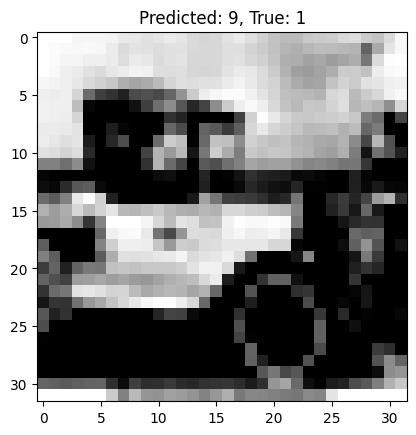

In [13]:
predicted_label, true_label = show_pred(testloader, model_cifar)

In [14]:
# show data classes
classes = trainset.classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [15]:
prompt = f"The CNN model predicted digit {classes[predicted_label]} for an image that should have been labeled as {classes[true_label]}. Explain why it might have made this prediction."
response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents=[prompt])
print(response.text)

There are several reasons why a CNN model might misclassify an image of an automobile as a digit truck (assuming "digit truck" is a valid class the model was trained on, or something close enough like "truck"). Here's a breakdown of common causes and explanations:

**1. Feature Similarity and Confusion:**

*   **Shared Visual Features:** Trucks and automobiles share many visual features, especially in certain viewpoints or lighting conditions. These include:
    *   **Wheels:** Both have wheels, and the model might focus on wheel presence without properly analyzing their size, number, and position.
    *   **Rectangular Shape:**  The overall shape of the body can be rectangular for both, especially for SUVs and some larger car models.
    *   **Headlights and Taillights:** Both have headlights and taillights, which might be confused if the dataset doesn't have enough variation in their appearance.
    *   **Grilles and Bumpers:**  Similar-looking grilles and bumpers can be misleading, 